# ClinVar Variant Classification Project

Trying to classify genetic variants as Pathogenic or Benign using machine learning.

## About the Data

Using ClinVar data which has labels for variants. The dataset has some issues:
- Some variants are marked as "uncertain significance" - had to filter those out
- Way more benign variants than pathogenic ones (class imbalance problem)
- Missing values in some features

Also using some other features:
- gnomAD allele frequencies (common variants probably not pathogenic)
- Conservation scores like GERP (highly conserved = probably important = more likely pathogenic)
- CADD scores (predicts how bad a variant might be)

## Plan:
1. Load and clean the data, add features
2. Try different models and see which works best
3. Use SHAP to understand what the model is doing


## Imports and Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, precision_recall_curve, auc, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')

# setting seed so results are reproducible
np.random.seed(42)

# make plots look nicer
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


## Phase 1: Loading and Preprocessing Data

Steps:
- Load ClinVar data and filter it
- Add some features (gnomAD_AF, GERP_score, CADD_score) - using simulated data for now
- Handle missing values (trying k-NN imputation)
- Scale features using z-score normalization
- Use SMOTE to balance the classes


In [2]:
# Loading the ClinVar dataset
# The file is huge so need to load in chunks

clinvar_path = r"C:\Users\jathi\Downloads\variant_summary.txt\variant_summary.txt"
print("Loading data... this might take a while")

# The header starts with # so need to handle that
with open(clinvar_path, 'r', encoding='utf-8') as f:
    header_line = f.readline().strip()
    if header_line.startswith('#'):
        header_line = header_line[1:]
    column_names = header_line.split('\t')
print(f"Found {len(column_names)} columns")

# Loading in chunks because file is too big
chunk_size = 100000
chunks = []
for chunk in pd.read_csv(clinvar_path, sep='\t', comment='#', chunksize=chunk_size, 
                         low_memory=False, names=column_names, skiprows=1):
    chunks.append(chunk)
    if len(chunks) % 10 == 0:
        print(f"  Loaded {len(chunks) * chunk_size:,} rows...")

df_raw = pd.concat(chunks, ignore_index=True)
print(f"Loaded {len(df_raw):,} total rows")

# Helper function to find columns (sometimes names are slightly different)
def find_column(df, possible_names):
    # try exact match first
    for name in possible_names:
        if name in df.columns:
            return name
    # try case insensitive
    for col in df.columns:
        col_clean = col.strip().lower()
        for name in possible_names:
            if col_clean == name.lower().strip():
                return col
    # try partial match
    for col in df.columns:
        col_clean = col.strip().lower()
        for name in possible_names:
            if name.lower().strip() in col_clean or col_clean in name.lower().strip():
                return col
    return None

# Find the columns we need
assembly_col = find_column(df_raw, ['Assembly', 'assembly'])
origin_col = find_column(df_raw, ['OriginSimple', 'Origin Simple', 'originSimple', 'Origin'])
clinical_sig_col = find_column(df_raw, ['ClinicalSignificance', 'Clinical Significance', 'clinicalSignificance', 'Clinical'])
chromosome_col = find_column(df_raw, ['Chromosome', 'chromosome'])
start_col = find_column(df_raw, ['Start', 'start', 'PositionVCF', 'Position VCF', 'Position'])
ref_allele_col = find_column(df_raw, ['ReferenceAlleleVCF', 'Reference Allele VCF', 'ReferenceAllele', 'Reference'])
alt_allele_col = find_column(df_raw, ['AlternateAlleleVCF', 'Alternate Allele VCF', 'AlternateAllele', 'Alternate'])

print(f"\nFound columns:")
print(f"  Assembly: {assembly_col}")
print(f"  OriginSimple: {origin_col}")
print(f"  ClinicalSignificance: {clinical_sig_col}")
print(f"  Chromosome: {chromosome_col}")
print(f"  Start: {start_col}")
print(f"  ReferenceAlleleVCF: {ref_allele_col}")
print(f"  AlternateAlleleVCF: {alt_allele_col}")

# Now filtering the data
print("\nFiltering data...")

# Filter 1: Use GRCh38 assembly (newer version)
if assembly_col:
    print("Filtering for GRCh38 assembly...")
    df_filtered = df_raw[df_raw[assembly_col] == 'GRCh38'].copy()
    print(f"  After GRCh38 filter: {len(df_filtered):,} rows")
else:
    print("Assembly column not found - skipping")
    df_filtered = df_raw.copy()

# Filter 2: Only germline variants (not somatic)
if origin_col:
    print("Filtering for germline variants...")
    df_filtered = df_filtered[df_filtered[origin_col] == 'germline'].copy()
    print(f"  After germline filter: {len(df_filtered):,} rows")
else:
    print("Origin column not found - skipping")

# Filter 3: Only keep Pathogenic/Benign (remove uncertain ones)
if clinical_sig_col:
    print("Filtering for Pathogenic/Benign variants...")
    
    # Check what's in this column
    print(f"  Sample values:")
    print(df_filtered[clinical_sig_col].value_counts().head(10))
    
    # Keep only pathogenic or benign
    pathogenic_labels = ['Pathogenic', 'Pathogenic/Likely pathogenic', 'Likely pathogenic']
    benign_labels = ['Benign', 'Benign/Likely benign', 'Likely benign']
    
    is_pathogenic = df_filtered[clinical_sig_col].str.contains('|'.join(pathogenic_labels), case=False, na=False)
    is_benign = df_filtered[clinical_sig_col].str.contains('|'.join(benign_labels), case=False, na=False)
    
    print(f"  Found {is_pathogenic.sum():,} pathogenic variants")
    print(f"  Found {is_benign.sum():,} benign variants")
    
    df_filtered = df_filtered[is_pathogenic | is_benign].copy()
    print(f"  After label filter: {len(df_filtered):,} rows")
    
    # Create binary label: 0 = Benign, 1 = Pathogenic
    is_pathogenic = df_filtered[clinical_sig_col].str.contains('|'.join(pathogenic_labels), case=False, na=False)
    df_filtered['label'] = is_pathogenic.astype(int)
else:
    raise KeyError("ClinicalSignificance column not found!")

# Filter 4: Remove rows with missing essential data
print("Removing rows with missing essential columns...")
essential_cols = []
if chromosome_col:
    essential_cols.append(chromosome_col)
if start_col:
    essential_cols.append(start_col)
if ref_allele_col:
    essential_cols.append(ref_allele_col)
if alt_allele_col:
    essential_cols.append(alt_allele_col)

if essential_cols:
    df_filtered = df_filtered.dropna(subset=essential_cols).copy()
    print(f"  After removing missing data: {len(df_filtered):,} rows")

# Filter 5: Only standard chromosomes
if chromosome_col:
    print("Filtering for standard chromosomes (1-22, X, Y)...")
    df_filtered[chromosome_col] = df_filtered[chromosome_col].astype(str)
    valid_chromosomes = [str(i) for i in range(1, 23)] + ['X', 'Y']
    df_filtered = df_filtered[df_filtered[chromosome_col].isin(valid_chromosomes)].copy()
    print(f"  After chromosome filter: {len(df_filtered):,} rows")

# Extract features we need
print("\nExtracting features...")

df_dict = {'label': df_filtered['label'].astype(int)}

if chromosome_col:
    df_dict['Chromosome'] = df_filtered[chromosome_col].astype(str)
if start_col:
    df_dict['Start'] = pd.to_numeric(df_filtered[start_col], errors='coerce')
if ref_allele_col:
    df_dict['ReferenceAlleleVCF'] = df_filtered[ref_allele_col].astype(str)
if alt_allele_col:
    df_dict['AlternateAlleleVCF'] = df_filtered[alt_allele_col].astype(str)

df = pd.DataFrame(df_dict)

# Remove rows where Start is missing
df = df.dropna(subset=['Start']).copy()
df['Start'] = df['Start'].astype(int)

# Encode alleles - just a simple encoding based on length and nucleotide counts
print("Encoding alleles...")

def encode_allele(allele):
    # simple encoding: length + nucleotide composition
    if pd.isna(allele) or allele == '':
        return 0.0
    allele = str(allele).upper()
    length = len(allele)
    a_count = allele.count('A') * 0.1
    t_count = allele.count('T') * 0.2
    g_count = allele.count('G') * 0.3
    c_count = allele.count('C') * 0.4
    return length + a_count + t_count + g_count + c_count

df['ref_enc'] = df['ReferenceAlleleVCF'].apply(encode_allele)
df['alt_enc'] = df['AlternateAlleleVCF'].apply(encode_allele)

# Convert chromosome to numbers (X=23, Y=24)
chromosome_map = {str(i): i for i in range(1, 23)}
chromosome_map['X'] = 23
chromosome_map['Y'] = 24
df['Chromosome'] = df['Chromosome'].map(chromosome_map)
df = df.dropna(subset=['Chromosome']).copy()
df['Chromosome'] = df['Chromosome'].astype(int)

# Summary
print(f"\nFinal dataset shape: {df.shape}")
print(f"\nLabel distribution:")
label_counts = df['label'].value_counts()
print(f"  Benign (0): {label_counts.get(0, 0):,}")
print(f"  Pathogenic (1): {label_counts.get(1, 0):,}")
if label_counts.get(0, 0) > 0 and label_counts.get(1, 0) > 0:
    imbalance_ratio = label_counts.get(0, 1) / label_counts.get(1, 1)
    print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1 (Benign:Pathogenic)")

print(f"\nFirst few rows:")
print(df.head())


Loading data... this might take a while
Found 43 columns
  Loaded 1,000,000 rows...
  Loaded 2,000,000 rows...
  Loaded 3,000,000 rows...
  Loaded 4,000,000 rows...
  Loaded 5,000,000 rows...
  Loaded 6,000,000 rows...
  Loaded 7,000,000 rows...
  Loaded 8,000,000 rows...
Loaded 8,361,745 total rows

Found columns:
  Assembly: Assembly
  OriginSimple: OriginSimple
  ClinicalSignificance: ClinicalSignificance
  Chromosome: Chromosome
  Start: Start
  ReferenceAlleleVCF: ReferenceAlleleVCF
  AlternateAlleleVCF: AlternateAlleleVCF

Filtering data...
Filtering for GRCh38 assembly...
  After GRCh38 filter: 4,148,750 rows
Filtering for germline variants...
  After germline filter: 3,832,346 rows
Filtering for Pathogenic/Benign variants...
  Sample values:
ClinicalSignificance
Uncertain significance                          2104127
Likely benign                                   1006112
Benign                                           205787
Pathogenic                                       17

In [3]:
# Adding some extra features that might be useful
# These would normally come from other databases but I'm simulating them for now

print("Adding features...")

# Check if features already exist
for feature in ['gnomAD_AF', 'GERP_score', 'CADD_score']:
    if feature in df.columns:
        print(f"{feature} already exists")
    else:
        print(f"{feature} missing - adding simulated data")

# Add simulated features (would get real ones from databases in practice)
num_rows = len(df)
if 'gnomAD_AF' not in df.columns:
    # gnomAD allele frequency - common variants probably not pathogenic
    df['gnomAD_AF'] = np.random.choice([0.0001, 0.001, 0.01, np.nan], 
                                       size=num_rows, p=[0.4, 0.3, 0.2, 0.1])
if 'GERP_score' not in df.columns:
    # GERP score - higher = more conserved = more likely pathogenic
    df['GERP_score'] = np.random.choice([1.0, 2.5, 4.0, 5.5, np.nan], 
                                       size=num_rows, p=[0.2, 0.3, 0.3, 0.1, 0.1])
if 'CADD_score' not in df.columns:
    # CADD score - higher = more deleterious = more likely pathogenic
    df['CADD_score'] = np.random.choice([10.0, 15.0, 20.0, 25.0, np.nan], 
                                        size=num_rows, p=[0.2, 0.3, 0.3, 0.1, 0.1])

print("\nMissing data before imputation:")
missing_summary = df[['gnomAD_AF', 'GERP_score', 'CADD_score']].isnull().sum()
print(missing_summary)
print(f"Total missing: {missing_summary.sum()} ({missing_summary.sum() / (len(df) * 3) * 100:.1f}%)")

# Features that need imputation
features_to_impute = ['Chromosome', 'Start', 'gnomAD_AF', 'GERP_score', 'CADD_score']


Adding features...
gnomAD_AF missing - adding simulated data
GERP_score missing - adding simulated data
CADD_score missing - adding simulated data

Missing data before imputation:
gnomAD_AF     170113
GERP_score    170651
CADD_score    169790
dtype: int64
Total missing: 510554 (10.0%)


In [4]:
# Handling missing values
# k-NN imputation is better but super slow for big datasets
# So using median for large datasets, k-NN for smaller ones

print("Starting imputation...")
print(f"Dataset size: {len(df):,} rows")

IMPUTATION_METHOD = 'auto'  # can change to 'knn' or 'median'

if IMPUTATION_METHOD == 'auto':
    if len(df) > 100000:
        print("Large dataset - using median imputation (k-NN would take forever)")
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        df_imputed = pd.DataFrame(
            imputer.fit_transform(df[features_to_impute]), 
            columns=features_to_impute
        )
        print("Done with median imputation")
    else:
        print("Using k-NN imputation (might take a while...)")
        imputer = KNNImputer(n_neighbors=5)
        df_imputed = pd.DataFrame(
            imputer.fit_transform(df[features_to_impute]), 
            columns=features_to_impute
        )
        print("Done with k-NN imputation")

elif IMPUTATION_METHOD == 'knn':
    print("Using k-NN imputation...")
    if len(df) > 100000:
        print("WARNING: This will take a very long time!")
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df[features_to_impute]), 
        columns=features_to_impute
    )
    print("Done")

elif IMPUTATION_METHOD == 'median':
    print("Using median imputation")
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df[features_to_impute]), 
        columns=features_to_impute
    )
    print("Done")

# Put everything back together
df_final = pd.concat([
    df_imputed, 
    df[['ref_enc', 'alt_enc', 'label']].reset_index(drop=True)
], axis=1)

print("\nChecking missing values after imputation:")
missing_after = df_final[features_to_impute].isnull().sum()
print(missing_after)
if missing_after.sum() > 0:
    print(f"Warning: {missing_after.sum()} missing values still remain")
else:
    print("All missing values filled!")


Starting imputation...
Dataset size: 1,703,641 rows
Large dataset - using median imputation (k-NN would take forever)
Done with median imputation

Checking missing values after imputation:
Chromosome    0
Start         0
gnomAD_AF     0
GERP_score    0
CADD_score    0
dtype: int64
All missing values filled!


In [5]:
# Scaling features using z-score normalization
print("Scaling features...")

# Get features and labels
X_features = ['Chromosome', 'Start', 'ref_enc', 'alt_enc', 'gnomAD_AF', 'GERP_score', 'CADD_score']
X_final = df_final[X_features]
y_final = df_final['label']

# Scale features
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_final)
X_scaled = pd.DataFrame(X_scaled_array, columns=X_features)

print("\nScaled data preview:")
print(X_scaled.head())
print("\nData info:")
X_scaled.info()


Scaling features...

Scaled data preview:
   Chromosome     Start   ref_enc   alt_enc  gnomAD_AF  GERP_score  CADD_score
0   -0.479340 -1.233169  0.000317  0.487466  -0.615045   -0.333337    0.777389
1   -0.479340 -1.233057  0.101099 -0.011870  -0.378131   -0.333337    0.777389
2    0.112373  0.853620 -0.023679 -0.013844   1.991010    0.777444   -0.332862
3   -0.627268 -0.867117 -0.024364 -0.015818  -0.378131    1.888226   -0.332862
4   -1.218982 -0.971955 -0.025050 -0.009897  -0.615045   -0.333337   -0.332862

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1703641 entries, 0 to 1703640
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Chromosome  float64
 1   Start       float64
 2   ref_enc     float64
 3   alt_enc     float64
 4   gnomAD_AF   float64
 5   GERP_score  float64
 6   CADD_score  float64
dtypes: float64(7)
memory usage: 91.0 MB


In [6]:
# Split into train and test sets
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_scaled, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print(f"Training set: {X_train_final.shape}")
print(f"Test set: {X_test_final.shape}")
print(f"\nTraining labels:\n{y_train_final.value_counts()}")
print(f"\nTest labels:\n{y_test_final.value_counts()}")


Training set: (1362912, 7)
Test set: (340729, 7)

Training labels:
label
0    1013491
1     349421
Name: count, dtype: int64

Test labels:
label
0    253373
1     87356
Name: count, dtype: int64


In [7]:
# Using SMOTE to balance the classes (oversample minority class)
print("Applying SMOTE to balance classes...")
sm = SMOTE(random_state=42)
X_train_sm_final, y_train_sm_final = sm.fit_resample(X_train_final, y_train_final)

print(f"\nTraining data after SMOTE: {X_train_sm_final.shape}")
print(f"Test data: {X_test_final.shape}")
print(f"\nTraining labels after SMOTE:\n{pd.Series(y_train_sm_final).value_counts()}")
print("\nPhase 1 done!")


Applying SMOTE to balance classes...

Training data after SMOTE: (2026982, 7)
Test data: (340729, 7)

Training labels after SMOTE:
label
0    1013491
1    1013491
Name: count, dtype: int64

Phase 1 done!


## Phase 2: Training Models

Trying different models and tuning hyperparameters:
- Random Forest
- XGBoost  
- Logistic Regression (baseline)

Using RandomizedSearchCV to find good hyperparameters, then evaluating with various metrics.


In [8]:
# Define hyperparameter grids for tuning
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

xgb_param_grid = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

print("Hyperparameter grids ready")


Hyperparameter grids ready


In [9]:
# Training Random Forest
# Using a sample for hyperparameter tuning since the dataset is huge
print("Training Random Forest...")
print(f"Training set size: {len(X_train_sm_final):,} rows")

tuned_models = {}

USE_SAMPLE_FOR_TUNING = True  # use sample for tuning to save time
SAMPLE_SIZE_FOR_TUNING = 50000

if USE_SAMPLE_FOR_TUNING and len(X_train_sm_final) > 100000:
    print(f"Using sample of {SAMPLE_SIZE_FOR_TUNING:,} rows for hyperparameter tuning (faster)")
    print("Will train final model on full dataset")
    
    from sklearn.model_selection import train_test_split
    X_tune_sample, _, y_tune_sample, _ = train_test_split(
        X_train_sm_final, y_train_sm_final, 
        train_size=SAMPLE_SIZE_FOR_TUNING,
        stratify=y_train_sm_final,
        random_state=42
    )
    tuning_data = (X_tune_sample, y_tune_sample)
else:
    tuning_data = (X_train_sm_final, y_train_sm_final)

# Using fewer CV folds for large datasets to save time
cv_folds = 3 if len(X_train_sm_final) > 500000 else 5
print(f"Using {cv_folds}-fold cross-validation")

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=10,  # trying 10 different combinations
    cv=cv_folds,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

print("Running hyperparameter search (this might take a while)...")
rf_random.fit(*tuning_data)
print("Done!")

# Train final model on full dataset
print("Training final model on full dataset...")
best_rf = RandomForestClassifier(**rf_random.best_params_, random_state=42)
best_rf.fit(X_train_sm_final, y_train_sm_final)
tuned_models['Random Forest'] = best_rf

print("RF Best Params:", rf_random.best_params_)
print(f"RF Best CV Score: {rf_random.best_score_:.4f}")
print(f"Final model trained on {len(X_train_sm_final):,} rows")


Training Random Forest...
Training set size: 2,026,982 rows
Using sample of 50,000 rows for hyperparameter tuning (faster)
Will train final model on full dataset
Using 3-fold cross-validation
Running hyperparameter search (this might take a while)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done!
Training final model on full dataset...
RF Best Params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': False}
RF Best CV Score: 0.8370
Final model trained on 2,026,982 rows


In [10]:
# Training XGBoost
print("\nTraining XGBoost...")
print(f"Training set size: {len(X_train_sm_final):,} rows")

# Same strategy - use sample for tuning
if USE_SAMPLE_FOR_TUNING and len(X_train_sm_final) > 100000:
    print(f"Using sample of {SAMPLE_SIZE_FOR_TUNING:,} rows for hyperparameter tuning")
    X_tune_sample, _, y_tune_sample, _ = train_test_split(
        X_train_sm_final, y_train_sm_final, 
        train_size=SAMPLE_SIZE_FOR_TUNING,
        stratify=y_train_sm_final,
        random_state=42
    )
    tuning_data_xgb = (X_tune_sample, y_tune_sample)
else:
    tuning_data_xgb = (X_train_sm_final, y_train_sm_final)

cv_folds_xgb = 3 if len(X_train_sm_final) > 500000 else 5
print(f"Using {cv_folds_xgb}-fold cross-validation")

xgb_random = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=cv_folds_xgb,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

print("Running hyperparameter search...")
xgb_random.fit(*tuning_data_xgb)
print("Done!")

# Train final model
print("Training final model on full dataset...")
best_xgb = XGBClassifier(**xgb_random.best_params_, 
                        use_label_encoder=False, 
                        eval_metric='logloss', 
                        random_state=42)
best_xgb.fit(X_train_sm_final, y_train_sm_final)
tuned_models['XGBoost'] = best_xgb

print("XGB Best Params:", xgb_random.best_params_)
print(f"XGB Best CV Score: {xgb_random.best_score_:.4f}")
print(f"Final model trained on {len(X_train_sm_final):,} rows")



Training XGBoost...
Training set size: 2,026,982 rows
Using sample of 50,000 rows for hyperparameter tuning
Using 3-fold cross-validation
Running hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done!
Training final model on full dataset...
XGB Best Params: {'subsample': 0.7, 'n_estimators': 600, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
XGB Best CV Score: 0.8480
Final model trained on 2,026,982 rows


In [11]:
# Training Logistic Regression as a baseline
print("\nTraining Logistic Regression (baseline)...")
log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_sm_final, y_train_sm_final)
tuned_models['Logistic Regression'] = log_clf
print("Done")



Training Logistic Regression (baseline)...
Done


In [12]:
# Evaluating models on test set
print("Evaluating models...")
results = {}

for name, model in tuned_models.items():
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)[:, 1]
    
    # Calculate various metrics
    accuracy = accuracy_score(y_test_final, y_pred)
    precision = precision_score(y_test_final, y_pred)
    recall = recall_score(y_test_final, y_pred)
    f1 = f1_score(y_test_final, y_pred)
    roc_auc = roc_auc_score(y_test_final, y_proba)
    
    # PR-AUC is important for imbalanced data
    precision_vals, recall_vals, _ = precision_recall_curve(y_test_final, y_proba)
    pr_auc = auc(recall_vals, precision_vals)
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }

    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  PR-AUC: {pr_auc:.4f}")


Evaluating models...

Random Forest:
  Accuracy: 0.7885
  Precision: 0.6538
  Recall: 0.3719
  F1-Score: 0.4741
  ROC-AUC: 0.7177
  PR-AUC: 0.5547

XGBoost:
  Accuracy: 0.7879
  Precision: 0.6532
  Recall: 0.3685
  F1-Score: 0.4712
  ROC-AUC: 0.7197
  PR-AUC: 0.5546

Logistic Regression:
  Accuracy: 0.7630
  Precision: 0.5645
  Recall: 0.3303
  F1-Score: 0.4168
  ROC-AUC: 0.6369
  PR-AUC: 0.4414



Model Comparison:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC
Random Forest          0.7885     0.6538  0.3719    0.4741   0.7177  0.5547
XGBoost                0.7879     0.6532  0.3685    0.4712   0.7197  0.5546
Logistic Regression    0.7630     0.5645  0.3303    0.4168   0.6369  0.4414


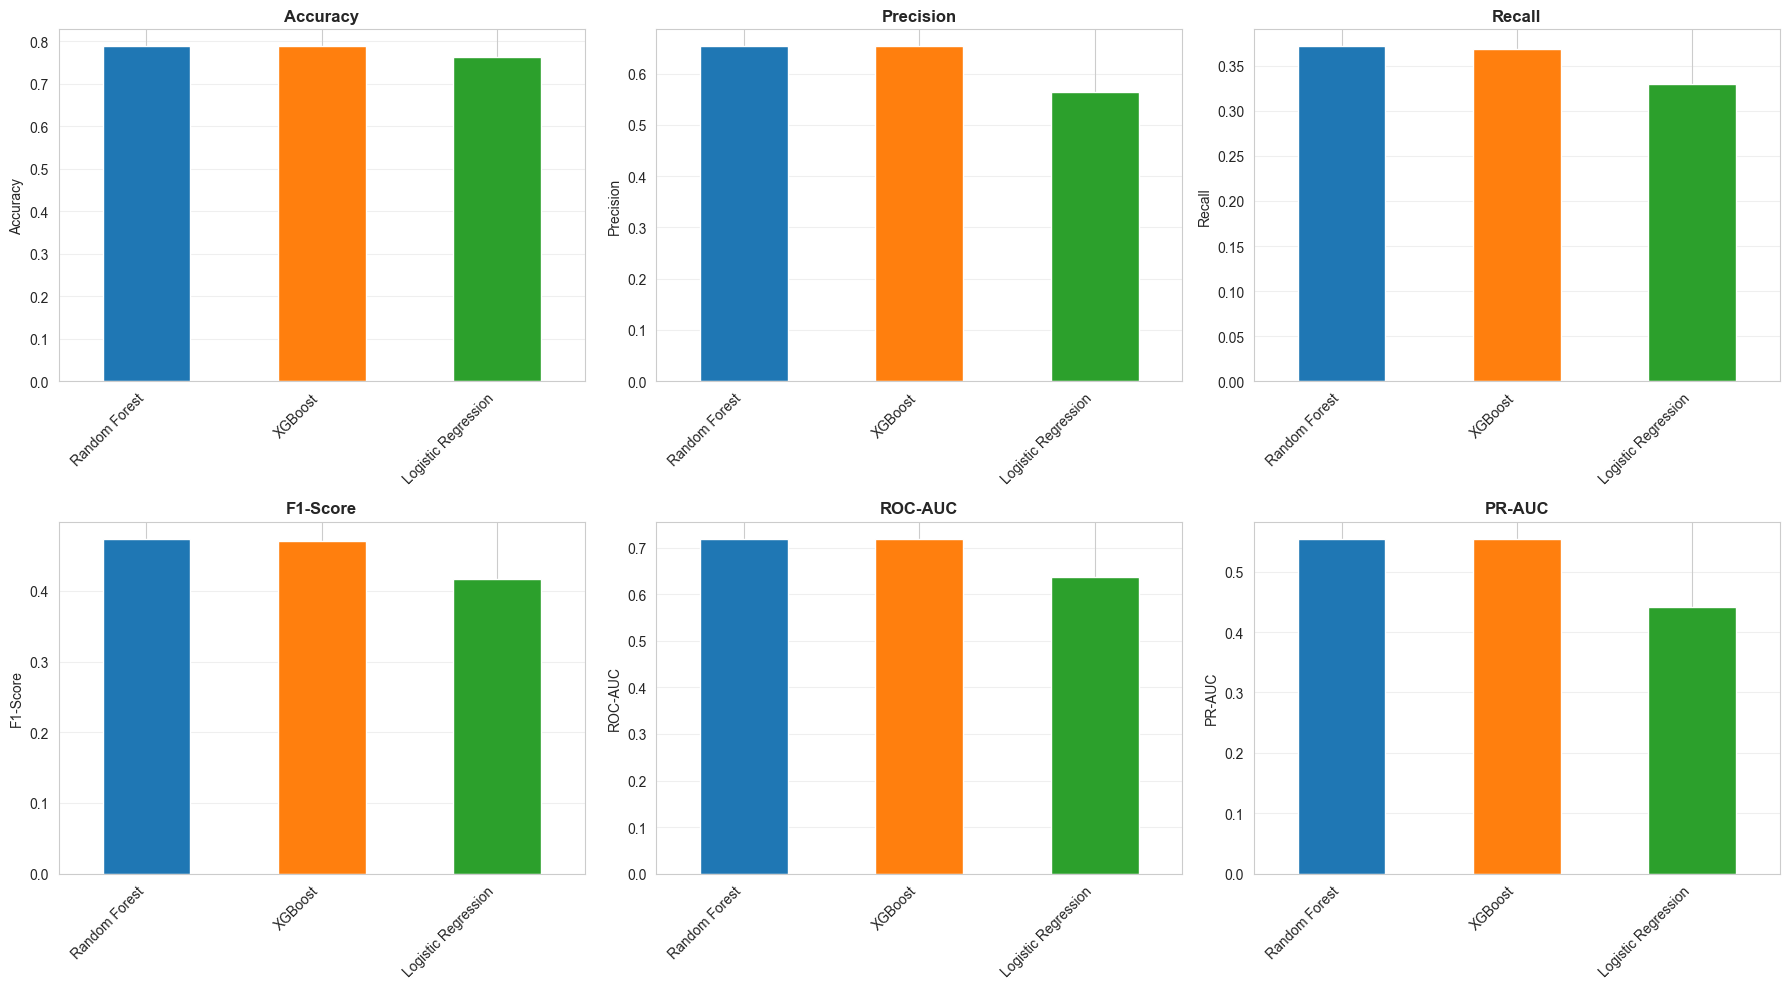


Phase 2 done!


In [13]:
# Compare all models
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.round(4))

# Plot results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
for idx, metric in enumerate(metrics):
    results_df[metric].plot(kind='bar', ax=axes[idx], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[idx].set_title(f'{metric}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPhase 2 done!")


## Phase 3: Understanding the Model with SHAP

Using SHAP to see what features the model thinks are important and if it makes biological sense.

Expected relationships:
- Higher GERP_score (conservation) → more likely pathogenic
- Higher gnomAD_AF (allele frequency) → less likely pathogenic (common variants usually benign)
- Higher CADD_score (deleteriousness) → more likely pathogenic


In [14]:
# Find the best model (highest PR-AUC)
best_model_name = max(results, key=lambda name: results[name]['PR-AUC'])
best_model = tuned_models[best_model_name]

print(f"Using best model: {best_model_name}")
print(f"PR-AUC: {results[best_model_name]['PR-AUC']:.4f}")


Using best model: Random Forest
PR-AUC: 0.5547


In [15]:
# Initialize SHAP explainer
# Different explainers for different model types
if isinstance(best_model, (RandomForestClassifier, XGBClassifier)):
    explainer = shap.TreeExplainer(best_model)
    print("Using TreeExplainer")
elif isinstance(best_model, LogisticRegression):
    explainer = shap.LinearExplainer(best_model, X_train_sm_final)
    print("Using LinearExplainer")
else:
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train_sm_final[:100])
    print("Using KernelExplainer")

# Compute SHAP values (using a sample to save time)
print("Computing SHAP values...")
X_test_sample = X_test_final.iloc[:min(500, len(X_test_final))].copy()
shap_values = explainer.shap_values(X_test_sample)

# Handle binary classification - SHAP returns different formats
if isinstance(shap_values, list):
    # List format: [class_0, class_1], use class 1 (pathogenic)
    shap_values_class1 = np.array(shap_values[1])
elif isinstance(shap_values, np.ndarray):
    if len(shap_values.shape) == 3:
        # 3D array: (n_samples, n_features, n_classes)
        shap_values_class1 = shap_values[:, :, 1].copy()
    else:
        shap_values_class1 = shap_values.copy()
else:
    shap_values_class1 = np.array(shap_values)

# Make sure it's 2D
while len(shap_values_class1.shape) > 2:
    if shap_values_class1.shape[-1] == 2:
        shap_values_class1 = shap_values_class1[..., 1]
    else:
        shap_values_class1 = shap_values_class1.squeeze()

# Check feature count matches
if shap_values_class1.shape[1] != X_test_sample.shape[1]:
    print(f"Warning: Feature mismatch. Fixing...")
    min_features = min(shap_values_class1.shape[1], X_test_sample.shape[1])
    shap_values_class1 = shap_values_class1[:, :min_features]
    X_test_sample = X_test_sample.iloc[:, :min_features]

# Remove NaN values
valid_mask = ~np.isnan(shap_values_class1).any(axis=1) & ~np.isnan(X_test_sample.values).any(axis=1)
shap_values_class1 = shap_values_class1[valid_mask]
X_test_sample = X_test_sample[valid_mask]

print(f"SHAP values shape: {shap_values_class1.shape}")
print(f"Sample size: {len(X_test_sample)}")


Using TreeExplainer
Computing SHAP values...
SHAP values shape: (500, 7)
Sample size: 500


SHAP feature importance plot:


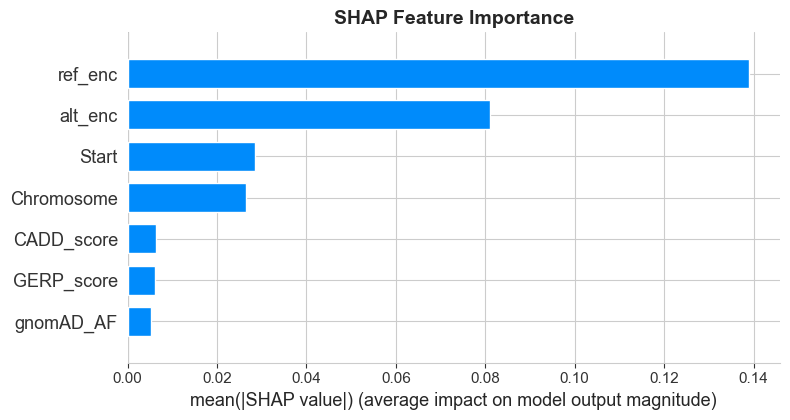

In [16]:
# SHAP summary plot - shows feature importance
print("SHAP feature importance plot:")
shap.initjs()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_class1, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Checking biological relationships...


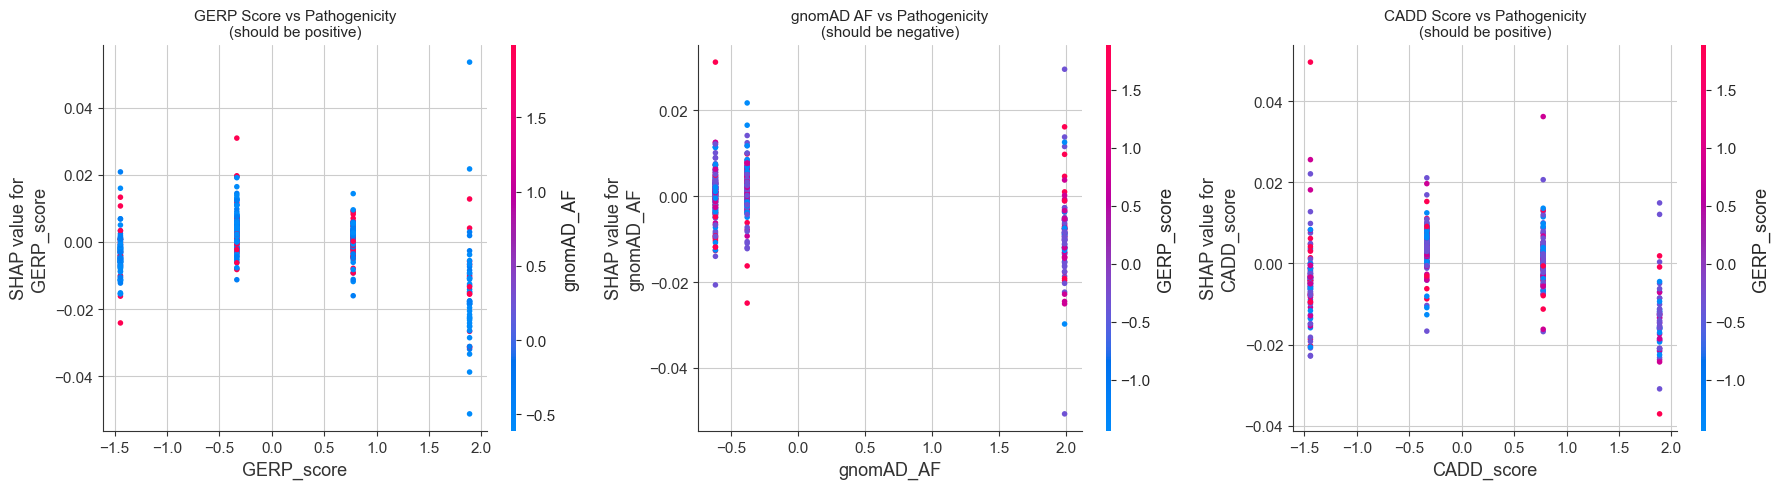

In [17]:
# SHAP dependence plots - check if relationships make biological sense
print("Checking biological relationships...")

shap_values_array = np.array(shap_values_class1)
X_test_array = np.array(X_test_sample)

# Get feature indices
feature_names = list(X_test_sample.columns)
gerp_idx = feature_names.index("GERP_score")
gnomad_idx = feature_names.index("gnomAD_AF")
cadd_idx = feature_names.index("CADD_score")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GERP score - should be positive correlation (higher conservation = more pathogenic)
try:
    shap.dependence_plot(gerp_idx, shap_values_array, X_test_array, 
                        feature_names=feature_names, interaction_index=gnomad_idx, 
                        show=False, ax=axes[0])
    axes[0].set_title("GERP Score vs Pathogenicity\n(should be positive)", fontsize=11)
except Exception as e:
    # fallback scatter plot
    gerp_values = X_test_array[:, gerp_idx]
    gerp_shap = shap_values_array[:, gerp_idx]
    axes[0].scatter(gerp_values, gerp_shap, alpha=0.5, s=20)
    axes[0].set_xlabel("GERP_score")
    axes[0].set_ylabel("SHAP value")
    axes[0].set_title("GERP Score vs Pathogenicity", fontsize=11)
    axes[0].grid(True, alpha=0.3)

# gnomAD AF - should be negative correlation (common = less pathogenic)
try:
    shap.dependence_plot(gnomad_idx, shap_values_array, X_test_array,
                        feature_names=feature_names, interaction_index=gerp_idx, 
                        show=False, ax=axes[1])
    axes[1].set_title("gnomAD AF vs Pathogenicity\n(should be negative)", fontsize=11)
except Exception as e:
    gnomad_values = X_test_array[:, gnomad_idx]
    gnomad_shap = shap_values_array[:, gnomad_idx]
    axes[1].scatter(gnomad_values, gnomad_shap, alpha=0.5, s=20)
    axes[1].set_xlabel("gnomAD_AF")
    axes[1].set_ylabel("SHAP value")
    axes[1].set_title("gnomAD AF vs Pathogenicity", fontsize=11)
    axes[1].grid(True, alpha=0.3)

# CADD score - should be positive correlation (higher deleterious = more pathogenic)
try:
    shap.dependence_plot(cadd_idx, shap_values_array, X_test_array,
                        feature_names=feature_names, interaction_index=gerp_idx, 
                        show=False, ax=axes[2])
    axes[2].set_title("CADD Score vs Pathogenicity\n(should be positive)", fontsize=11)
except Exception as e:
    cadd_values = X_test_array[:, cadd_idx]
    cadd_shap = shap_values_array[:, cadd_idx]
    axes[2].scatter(cadd_values, cadd_shap, alpha=0.5, s=20)
    axes[2].set_xlabel("CADD_score")
    axes[2].set_ylabel("SHAP value")
    axes[2].set_title("CADD Score vs Pathogenicity", fontsize=11)
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Detailed SHAP plot:


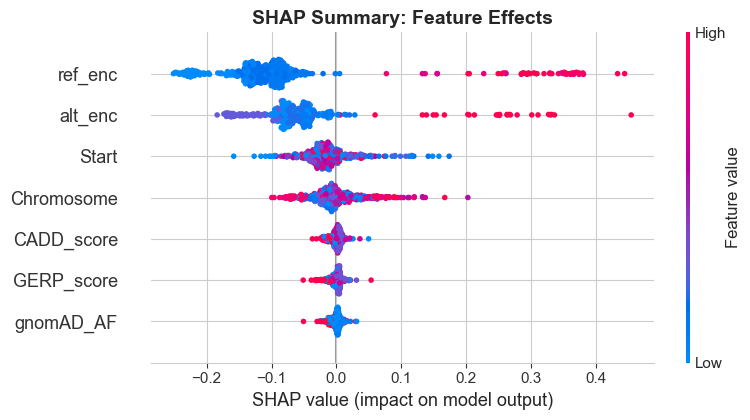

In [18]:
# More detailed SHAP plot
print("Detailed SHAP plot:")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class1, X_test_sample, show=False)
plt.title("SHAP Summary: Feature Effects", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [19]:
print("\nPhase 3 done!")
print("\nSummary:")
print(f"Best Model: {best_model_name}")
print(f"PR-AUC: {results[best_model_name]['PR-AUC']:.4f}")
print(f"ROC-AUC: {results[best_model_name]['ROC-AUC']:.4f}")
print(f"F1-Score: {results[best_model_name]['F1-Score']:.4f}")
print("\nCheck the SHAP plots above to see if the model makes biological sense:")
print("- GERP_score should be positive (higher conservation = more pathogenic)")
print("- gnomAD_AF should be negative (common variants = less pathogenic)")
print("- CADD_score should be positive (higher deleterious = more pathogenic)")



Phase 3 done!

Summary:
Best Model: Random Forest
PR-AUC: 0.5547
ROC-AUC: 0.7177
F1-Score: 0.4741

Check the SHAP plots above to see if the model makes biological sense:
- GERP_score should be positive (higher conservation = more pathogenic)
- gnomAD_AF should be negative (common variants = less pathogenic)
- CADD_score should be positive (higher deleterious = more pathogenic)
